# SNN that detects High Frequency Oscillations (HFOs) with constant parameters
This notebook is a simple example of how to use a Spiking Neural Network (SNN) to detect HFOs

### What is an HFO?
High Frequency Oscillations (HFOs) are a type of brain activity that occurs in the range of 80-500 Hz. They are believed to be related to the generation of seizures in patients with epilepsy. The detection of HFOs is an important task in the diagnosis and treatment of epilepsy. 

In terms of electrophysiology, HFOs are characterized by their high frequency and short duration, often lasting only a few milliseconds. The wave of a typical HFO consists of at least 4 UP and DOWN waves.

In [74]:
from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense
import numpy as np

LIF?

Init signature: LIF(*args, **kwargs)
Docstring:     
Leaky-Integrate-and-Fire (LIF) neural Process.

LIF dynamics abstracts to:
u[t] = u[t-1] * (1-du) + a_in         # neuron current
v[t] = v[t-1] * (1-dv) + u[t] + bias  # neuron voltage
s_out = v[t] > vth                    # spike if threshold is exceeded
v[t] = 0                              # reset at spike

Parameters
----------
shape : tuple(int)
    Number and topology of LIF neurons.
u : float, list, numpy.ndarray, optional
    Initial value of the neurons' current.
v : float, list, numpy.ndarray, optional
    Initial value of the neurons' voltage (membrane potential).
du : float, optional
    Inverse of decay time-constant for current decay. Currently, only a
    single decay can be set for the entire population of neurons.
dv : float, optional
    Inverse of decay time-constant for voltage decay. Currently, only a
    single decay can be set for the entire population of neurons.
bias_mant : float, list, numpy.ndarray, optiona

### Check WD (change if necessary) and file loading

In [75]:
# Show current directory
import os
curr_dir = os.getcwd()
print(curr_dir)

# Check if the current WD is the file location
if "/src/hfo/snn" not in os.getcwd():
    # Set working directory to this file location
    file_location = f"{os.getcwd()}/thesis-lava/src/hfo/snn"
    print("File Location: ", file_location)

    # Change the current working Directory
    os.chdir(file_location)

    # New Working Directory
    print("New Working Directory: ", os.getcwd())

/home/monkin/Desktop/feup/thesis/lava/src/hfo/snn


## Create the Custom Input Layer

### Define function to read the input data from the csv file and generate the corresponding spike events

In [76]:
import pandas as pd

def read_spike_events(file_path: str):
    """Reads the spike events from the input file and returns them as a numpy array

    Args:
        file_path (str): name of the file containing the spike events
    """
    spike_events = []

    try:
        # Read the spike events from the file
        df = pd.read_csv(file_path, header=None)

        # Detect errors
        if df.empty:
            raise Exception("The input file is empty")

        # Convert the scientific notation values to integers if any exist
        df = df.applymap(lambda x: int(float(x)) if (isinstance(x, str) and 'e' in x) else x)

        # Convert the dataframe to a numpy array
        spike_events = df.to_numpy()
        return spike_events[0]
    except Exception as e:
        print("Unable to read the input file: ", file_path, " error:", e)

    return spike_events

### Load the UP and DOWN spikes from the CSV Files

In [77]:
from utils.input import read_spike_events
from utils.io import preview_np_array

# Call the function to read the spike events
up_spikes_file_path = "./data/fr_up_spike_train_3.csv"
up_spike_train = read_spike_events(up_spikes_file_path)

down_spikes_file_path = "./data/fr_down_spike_train_-3.csv"
down_spike_train = read_spike_events(down_spikes_file_path)

preview_np_array(up_spike_train, "Spike Events")
preview_np_array(down_spike_train, "Spike Events")

Spike Events Shape: (198, 2).
Preview: [[1.00537109e+03 6.30000000e+01]
 [1.00878906e+03 6.30000000e+01]
 [1.01220703e+03 6.30000000e+01]
 [1.01269531e+03 6.30000000e+01]
 [1.01611328e+03 6.30000000e+01]
 ...
 [1.14575684e+05 6.30000000e+01]
 [1.14576172e+05 6.30000000e+01]
 [1.14579102e+05 6.30000000e+01]
 [1.14582520e+05 6.30000000e+01]
 [1.14585938e+05 6.30000000e+01]]
Spike Events Shape: (196, 2).
Preview: [[1.00439453e+03 6.30000000e+01]
 [1.00732422e+03 6.30000000e+01]
 [1.01123047e+03 6.30000000e+01]
 [1.01416016e+03 6.30000000e+01]
 [1.01806641e+03 6.30000000e+01]
 ...
 [1.14574219e+05 6.30000000e+01]
 [1.14574707e+05 6.30000000e+01]
 [1.14577637e+05 6.30000000e+01]
 [1.14581055e+05 6.30000000e+01]
 [1.14584961e+05 6.30000000e+01]]


### Define the SpikeEvent Generator Interface

In [78]:
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import OutPort

class SpikeEventGen(AbstractProcess):
    """Input Process that generates spike events based on the input file

    Args:
        @out_shape (tuple): Shape of the output port
        @exc_spike_events (np.ndarray): Excitatory spike events
        @inh_spike_event (np.ndarray): Inhibitory spike events
        @name (str): Name of the process
    """
    def __init__(self, out_shape: tuple, exc_spike_events: np.ndarray, inh_spike_event: np.ndarray, name: str) -> None:
        super().__init__(name=name)
        self.s_out = OutPort(shape=out_shape)
        self.exc_spike_events = Var(shape=exc_spike_events.shape, init=exc_spike_events)
        self.inh_spike_events = Var(shape=inh_spike_event.shape, init=inh_spike_event)


## Define the Architecture of the Network

In [79]:
# Define the number of neurons in the Input Spike Event Generator
n_spike_gen = 2  # 2 neurons in the input spike event generator

# Define the number of neurons in each LIF Layer
n_lif1 = 256   # 256 neurons in the first LIF layer
# n2 = 1  # 1 neuron in the second layer

### Choose the LIF Models to use

In [80]:
use_refractory = False

### Define the LIF parameters

In [81]:
# Constants for the LIF Process
v_th = 1
v_init = 0

# LIF1 Process
dv1 = 0.07
du1 = 0.2  

### Create the LIF Processes

In [82]:
if not use_refractory:
    # Create LIF1 process
    lif1 = LIF(shape=(n_lif1,),  # There are 2 neurons
            vth=v_th,  # TODO: Verify these initial values
            v=v_init,
            dv=dv1,    # Inverse of decay time-constant for voltage decay
            du=du1,  # Inverse of decay time-constant for current decay
            bias_mant=0,
            bias_exp=0,
            name="lif1")

### Create the Refractory LIF Processes

In [83]:
from lava.proc.lif.process import LIFRefractory
from lava.magma.core.process.process import LogConfig
import logging

# Constants for the Refractory LIF Process
refrac_period = 20   # Number of time-steps for the refractory period

if use_refractory:
    # Create Refractory LIF1 process
    lif1 = LIFRefractory(shape=(n_lif1,),  # There are 2 neurons
            vth=v_th,  # TODO: Verify these initial values
            v=v_init,
            dv=dv1,    # Inverse of decay time-constant for voltage decay
            du=du1,  # Inverse of decay time-constant for current decay
            bias_mant=0,
            bias_exp=0,
            refractory_period=refrac_period,
            name="lif1",
            # log_config=LogConfig(level=logging.DEBUG, level_console=logging.DEBUG, logs_to_file=False)
            )

### Create a `ConfigTimeConstantsLIF` object

#### Define the time constants for the `ConfigTimeConstantsLIF` neurons

In [84]:
from utils.neuron_dynamics import time_constant_to_fraction
# Create the np arrays for the time constants of each neuron

# For Fast-Ripples, the time constants of each neuron are drawn randomly from a normal distribution with an IQR of [0.3ms, 2.7ms]
fr_IQR = [0.3, 2.7] # Inter-Quartile Range for the time constants of the Fast-Ripple neurons
fr_mu = np.mean(fr_IQR)  # Midpoint of the IQR

# Calculate the standard deviation of the normal distribution
# For a normal distribution, the first quartile is ~0.675 standard deviations below the mean
fr_std_dev = (fr_IQR[1] - fr_IQR[0]) / (2 * 0.675)  # standard deviation is the IQR divided by 2*0.675

print("fr_IQR: ", fr_IQR)

fr_IQR:  [0.3, 2.7]


In [85]:
# Generate the time constants for the Fast-Ripple neurons
config_time_constant = np.random.normal(fr_mu, fr_std_dev, n_lif1)
# preview_np_array(config_time_constant, "config_time_constant", edge_items=10)
print("Min and max time constants before:", np.min(config_time_constant), np.max(config_time_constant))


# Cannot have negative time constants. Make them 0 or positive?
# config_time_constant = np.clip(config_time_constant, a_min=0, a_max=None)
config_time_constant = np.abs(config_time_constant)
print("Min and max time constants after:", np.min(config_time_constant), np.max(config_time_constant))

Min and max time constants before: -3.1234587442859 8.484282298326857
Min and max time constants after: 0.005401226139482018 8.484282298326857


In [86]:
# Conver the time constants to fractions (du values) that are used in the LAVA Processes dynamics
config_time_constant_frac = time_constant_to_fraction(config_time_constant)
preview_np_array(config_time_constant_frac, "config_time_constant_frac", edge_items=5)
print(np.min(config_time_constant_frac), np.max(config_time_constant_frac))


config_time_constant_frac Shape: (256,).
Preview: [0.43742736 0.5656001  0.36668685 0.30787085 0.98947116 ... 0.54907258
 0.72401971 0.91595475 0.23799799 0.97510171]
0.11118397232894428 1.0


In [87]:
from lava.proc.lif.process import ConfigTimeConstantsLIF

configLIF = ConfigTimeConstantsLIF(shape=(n_lif1,),  # There are 2 neurons
            vth=v_th,  # TODO: Verify these initial values
            v=v_init,
            dv=dv1,    # Inverse of decay time-constant for voltage decay
            du=config_time_constant_frac,  # Inverse of decay time-constant for current decay
            bias_mant=0,
            bias_exp=0,
            name="lif1")

configLIF.du

Variable: du
    shape: (256,)
    init: [0.43742736 0.5656001  0.36668685 0.30787085 0.98947116 ... 0.54907258
 0.72401971 0.91595475 0.23799799 0.97510171]
    shareable: True
    value: [0.43742736 0.5656001  0.36668685 0.30787085 0.98947116 ... 0.54907258
 0.72401971 0.91595475 0.23799799 0.97510171]

### Create the Dense Layers

In [88]:
# Create Dense Process to connect the input layer and LIF1
# create weights of the dense layer
# dense_weights_input = np.eye(N=n1, M=n1)
# Fully Connected Layer from n_spike_gen neurons to n_lif1 neurons
dense_weights_input = np.ones(shape=(n_lif1, n_spike_gen))

# Make the weights (synapses) connecting the odd-parity neurons of the input layer to the network negative (inhibitory)
dense_weights_input[:, 1::2] *= -1

# multiply the weights of the Dense layer by a constant
weights_scale_input = 0.7
dense_weights_input *= weights_scale_input
dense_input = Dense(weights=np.array(dense_weights_input), name="DenseInput")

#### Look at the weights of the Dense Layers

In [89]:
# Weights of the Input Dense Layer
dense_input.weights.get()

array([[ 0.7, -0.7],
       [ 0.7, -0.7],
       [ 0.7, -0.7],
       [ 0.7, -0.7],
       [ 0.7, -0.7],
       ...,
       [ 0.7, -0.7],
       [ 0.7, -0.7],
       [ 0.7, -0.7],
       [ 0.7, -0.7],
       [ 0.7, -0.7]])

### Map the input channels to the corresponding indexes in the input layer
Since the input channels in the input file may be of any number, we need to **map the input channels to the corresponding indexes in the input layer**. This is done by the `channel_map` dictionaries.

The network expects an UP and DOWN spike train for each channel. Thusly, let's define 2 dictionaries, one for the UP spikes and one for the DOWN spikes. We want the UP and DOWN spike trains to be followed by each other in the input layer for each channel.

In [90]:
# Map the channels of the input file to the respective index in the output list of SpikeEventGen

# Define the mapping of the channels of the UP spike train to the respective index in the output list of SpikeEventGen
up_channel_map = {63: 0}
# Define the mapping of the channels of the DOWN spike train to the respective index in the output list of SpikeEventGen
down_channel_map = {63: 1}

## Define constants related to the simulation time

In [91]:
init_offset = 1000  # 33400      #   
virtual_time_step_interval = 1  # TODO: Check if this should be the time-step value. it is not aligned with the sampling rate of the input data

num_steps = 300    # 200 # Number of steps to run the simulation

### Implement the `SpikeEventGenerator` Model

In [92]:
from lava.magma.core.model.py.model import PyLoihiProcessModel  # Processes running on CPU inherit from this class
from lava.magma.core.resources import CPU
from lava.magma.core.decorator import implements, requires
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.model.py.ports import PyOutPort

@implements(proc=SpikeEventGen, protocol=LoihiProtocol)
@requires(CPU)
class PySpikeEventGenModel(PyLoihiProcessModel):
    """Spike Event Generator Process implementation running on CPU (Python)
    Args:
    """
    s_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)   # IT IS POSSIBLE TO SEND FLOATS AFTER ALL
    exc_spike_events: np.ndarray = LavaPyType(np.ndarray, np.ndarray)
    inh_spike_events: np.ndarray = LavaPyType(np.ndarray, np.ndarray)

    def __init__(self, proc_params) -> None:
        super().__init__(proc_params=proc_params)
        # print("spike events", self.spike_events.__str__())    # TODO: Check why during initialization the variable prints the class, while during run it prints the value
        self.curr_exc_idx = 0     # Index of the next excitatory spiking event to send
        self.curr_inh_idx = 0     # Index of the next inhibitory spiking event to send
        self.virtual_time_step_interval = virtual_time_step_interval  # 1000    # Arbitrary time between time steps (in microseconds). This is not a real time interval (1000ms = 1s)
        self.init_offset = init_offset        # 698995               # Arbitrary offset to start the simulation (in microseconds)

    def run_spk(self) -> None:
        spike_data = np.zeros(self.s_out.shape) # Initialize the spike data to 0
        
        #print("time step:", self.time_step)

        # If the current simulation time is greater than a spike event, send a spike in the corresponding channel
        currTime = self.init_offset + self.time_step*self.virtual_time_step_interval

        spiking_channels = set()   # List of channels that will spike in the current time step

        # Add the excitatory spike events to the spike_date
        while (self.curr_exc_idx < len(self.exc_spike_events)) and currTime >= self.exc_spike_events[self.curr_exc_idx][0]:
            # Get the channel of the current spike event
            curr_channel = self.exc_spike_events[self.curr_exc_idx][1]

            # Check if the channel is valid (belongs to a channel in the up_channel_map therefore it has an output index)
            if curr_channel not in up_channel_map:
                self.curr_exc_idx += 1
                continue    # Skip the current spike event

            # Check if the next spike belongs to a channel that will already spike in this time step
            # If so, we don't add the event and stop looking for more events
            if curr_channel in spiking_channels:
                break

            # Add the channel to the list of spiking channels
            spiking_channels.add(curr_channel)

            # Get the output index of the current channel according to the up_channel_map
            out_idx = up_channel_map[curr_channel]
            if out_idx < self.s_out.shape[0]:   # Check if the channel is valid
                # Update the spike_data with the excitatory spike event (value = 1.0)
                spike_data[out_idx] = 1.0   # Send spike (value corresponds to the punctual current of the spike event)

            # Move to the next spike event
            self.curr_exc_idx += 1

        # Add the inhibitory spike events to the spike_date
        while (self.curr_inh_idx < len(self.inh_spike_events)) and currTime >= self.inh_spike_events[self.curr_inh_idx][0]:
            # Get the channel of the current spike event
            curr_channel = self.inh_spike_events[self.curr_inh_idx][1]

            # Check if the channel is valid (belongs to a channel in the down_channel_map therefore it has an output index)
            if curr_channel not in down_channel_map:
                self.curr_inh_idx += 1
                continue    # Skip the current spike event

            # Check if the next spike belongs to a channel that will already spike in this time step
            # If so, we don't add the event and stop looking for more events
            if curr_channel in spiking_channels:
                break

            # Add the channel to the list of spiking channels
            spiking_channels.add(curr_channel)

            # Get the output index of the current channel according to the down_channel_map
            out_idx = down_channel_map[curr_channel]
            if out_idx < self.s_out.shape[0]:   # Check if the channel is valid
                # It is not possible to send negative values or floats in the spike_data. The weight of the synapse should do the inhibition
                spike_data[out_idx] = 1.0   # Send spike (value corresponds to the punctual current of the spike event)

            # Move to the next spike event
            self.curr_inh_idx += 1


        if len(spiking_channels) > 0:   # Print the spike event if there are any spikes
            print(f"""Sending spike event at time: {currTime}({self.time_step}). Last (E/I) spike idx: {self.curr_exc_idx-1}/{self.curr_inh_idx-1}
                Spike times: {self.exc_spike_events[self.curr_exc_idx-1][0] if self.curr_exc_idx > 0 else "?"}/\
{self.inh_spike_events[self.curr_inh_idx-1][0] if self.curr_inh_idx > 0 else "?"}
                Spike_data: {spike_data}\n""")

        # Send spikes if self.curr_exc_idx > 0 else "?"
        # print("sending spike_data: ", spike_data, " at step: ", self.time_step)
        self.s_out.send(spike_data)

        # Stop the Process if there are no more spike events to send. (It will stop all the connected processes)
        # TODO: Should it be another process that stops the simulation? Such as the last LIF process
        # if self.curr_spike_idx >= 5: # len(self.spike_events):
        #    self.pause()

## Connect the Layers
To define the connectivity between the `SpikeGenerator` and the first `LIF` population, we use another `Dense` Layer.

In [93]:
# Create the Input Process
spike_event_gen = SpikeEventGen(out_shape=(n_spike_gen,), exc_spike_events=up_spike_train, inh_spike_event=down_spike_train, name="SpikeEventsGenerator")

# If I connect the SpikeEventGen to the Dense Layer, the a_out value of the custom input will be rounded to 0 or 1 in the Dense Layer (it will not be a float) 
# However, setting the Dense weights to a float works instead
# Connect the SpikeEventGen to the Dense Layer
spike_event_gen.s_out.connect(dense_input.s_in)

# Connect the Dense_Input to the LIF1 Layer
dense_input.a_out.connect(configLIF.a_in)

### Take a look at the connections in the Input Layer

In [94]:
for proc in [spike_event_gen, dense_input, configLIF]:
    for port in proc.in_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")
    for port in proc.out_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")

Proc: SpikeEventsGenerator Port Name: s_out Size: 2
Proc: DenseInput Port Name: s_in  Size: 2
Proc: DenseInput Port Name: a_out Size: 256
Proc: lif1  Port Name: a_in  Size: 256
Proc: lif1  Port Name: s_out Size: 256


### Record Internal Vars over time
To record the evolution of the internal variables over time, we need a `Monitor`. For this example, we want to record the membrane potential of the `LIF` Layer, hence we need 1 `Monitors`.

We can define the `Var` that a `Monitor` should record, as well as the recording duration, using the `probe` function

In [95]:
from lava.proc.monitor.process import Monitor

monitor_lif1_v = Monitor()
monitor_lif1_u = Monitor()

# Connect the monitors to the variables we want to monitor
monitor_lif1_v.probe(configLIF.v, num_steps)
monitor_lif1_u.probe(configLIF.u, num_steps)

## Execution
Now that we have defined the network, we can execute it. We will use the `run` function to execute the network.

### Run Configuration and Conditions

In [96]:
from lava.magma.core.run_conditions import RunContinuous, RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg

# run_condition = RunContinuous()   # TODO: Change to this one
run_condition = RunSteps(num_steps=num_steps)
run_cfg = Loihi1SimCfg(select_tag="floating_pt")   # TODO: Check why we need this select_tag="floating_pt"

### Execute

In [97]:
configLIF.run(condition=run_condition, run_cfg=run_cfg)

Sending spike event at time: 1005(5). Last (E/I) spike idx: -1/0
                Spike times: ?/1004.39453125
                Spike_data: [0. 1.]

Sending spike event at time: 1006(6). Last (E/I) spike idx: 0/0
                Spike times: 1005.37109375/1004.39453125
                Spike_data: [1. 0.]

Sending spike event at time: 1008(8). Last (E/I) spike idx: 0/1
                Spike times: 1005.37109375/1007.32421875
                Spike_data: [0. 1.]

Sending spike event at time: 1009(9). Last (E/I) spike idx: 1/1
                Spike times: 1008.7890625/1007.32421875
                Spike_data: [1. 0.]

Sending spike event at time: 1012(12). Last (E/I) spike idx: 1/2
                Spike times: 1008.7890625/1011.23046875
                Spike_data: [0. 1.]

Sending spike event at time: 1013(13). Last (E/I) spike idx: 2/2
                Spike times: 1012.20703125/1011.23046875
                Spike_data: [1. 0.]

Sending spike event at time: 1014(14). Last (E/I) spike idx: 3/

### Retrieve recorded data

In [98]:
data_lif1_v = monitor_lif1_v.get_data()
data_lif1_u = monitor_lif1_u.get_data()

data_lif1 = data_lif1_v.copy()
data_lif1["lif1"]["u"] = data_lif1_u["lif1"]["u"]   # Merge the dictionaries to contain both voltage and current


In [99]:
configLIF

In [100]:
# Check the shape to verify if it is printing the voltage for every step
print(len(data_lif1['lif1']['v']))     # Indeed, there are 300 values (same as the number of steps we ran the simulation for)

300


### Plot the recorded data

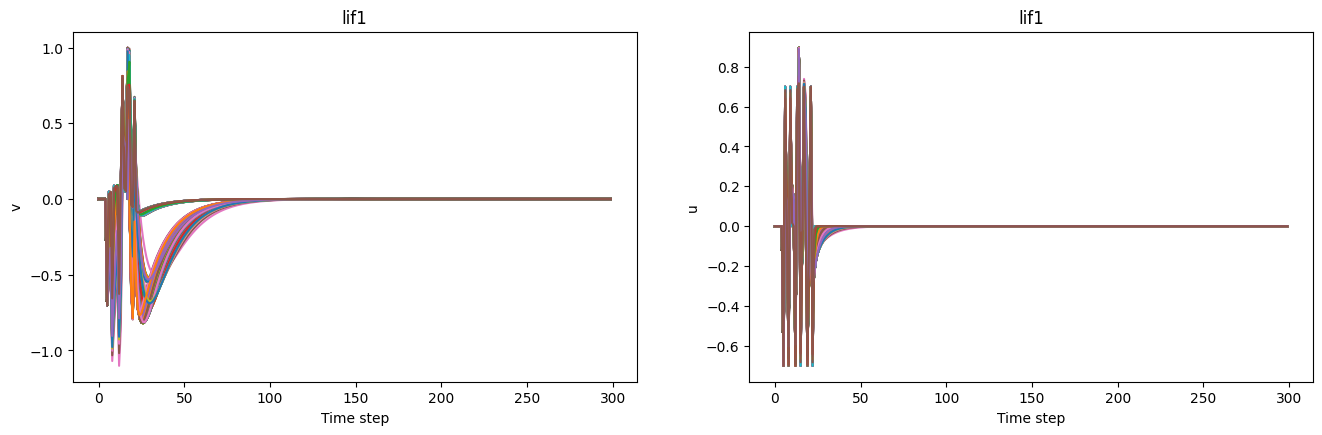

In [101]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

# Create a subplot for each monitored variable
fig = plt.figure(figsize=(16, 10))
ax0 = fig.add_subplot(221)
ax0.set_title('Voltage (V) / time step')
ax1 = fig.add_subplot(222)
ax1.set_title('Current (U) / time step')


# Plot the data
monitor_lif1_v.plot(ax0, lif1.v)
monitor_lif1_u.plot(ax1, lif1.u)


## Find the timesteps where the network spiked

In [102]:
from utils.data_analysis import find_spike_times

voltage_arr_1 = np.array(data_lif1['lif1']['v'])
# preview_np_array(voltage_arr_1, "Voltage Array")

# Call the find_spike_times util function that detects the spikes in a voltage array
spike_times_lif1 = find_spike_times(voltage_arr_1, v_th)

for (spike_time, neuron_idx) in spike_times_lif1:
    print(f"Spike time: {init_offset + spike_time * virtual_time_step_interval} (iter. {spike_time}) at neuron: {neuron_idx}")


Spike time: 1018 (iter. 18) at neuron: 0


## View the Voltage and Current dynamics with an interactive plot

Grab the data from the recorded variables

In [103]:
# LIF1 variables
lif1_voltage_vals = data_lif1['lif1']['v']
lif1_current_vals = data_lif1['lif1']['u']

# print("voltage head: ", lif1_voltage_vals[:10])
preview_np_array(lif1_voltage_vals, "Voltage Values", edge_items=3)

Voltage Values Shape: (300, 256).
Preview: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-2.44982054e-09 -2.07922122e-09 -2.72117614e-09 ... -2.23865047e-10
  -2.62770448e-09 -2.09235821e-10]
 [-2.27833311e-09 -1.93367573e-09 -2.53069381e-09 ... -2.08194494e-10
  -2.44376516e-09 -1.94589313e-10]
 [-2.11884979e-09 -1.79831843e-09 -2.35354524e-09 ... -1.93620879e-10
  -2.27270160e-09 -1.80968062e-10]]


## Assemble the values to be plotted

In [104]:
from utils.line_plot import create_fig  # Import the function to create the figure
from bokeh.models import Range1d

# Define the x and y values
x = [val + init_offset for val in range(num_steps)]

v_y1 = [val[0] for val in lif1_voltage_vals]
v_y2 = [val[1] for val in lif1_voltage_vals]
v_y3 = [val[2] for val in lif1_voltage_vals]
v_y4 = [val[3] for val in lif1_voltage_vals]
v_y5 = [val[4] for val in lif1_voltage_vals]
v_y6 = [val[5] for val in lif1_voltage_vals]
v_y7 = [val[6] for val in lif1_voltage_vals]
v_y8 = [val[7] for val in lif1_voltage_vals]
v_y9 = [val[8] for val in lif1_voltage_vals]
v_y10 = [val[9] for val in lif1_voltage_vals]

# Create the plot
voltage_lif1_y_arrays = [
    (v_y1, "Neuron. 0"), (v_y2, "Neuron. 1"), (v_y3, "Neuron. 2"),
    (v_y4, "Neuron. 3"), (v_y5, "Neuron. 4"), # (v_y6, "Neuron. 5"),
    # (v_y7, "Neuron. 6"), (v_y8, "Neuron. 7"), (v_y9, "Neuron. 8"),
    # (v_y10, "Neuron. 9")
]    # List of tuples containing the y values and the legend label
# Define the box annotation parameters
box_annotation_voltage = {
    "bottom": 0,
    "top": v_th,
    "left": 0,
    "right": num_steps,
    "fill_alpha": 0.03,
    "fill_color": "green"
}

# Create the LIF1 Voltage
voltage_lif1_plot = create_fig(
    title="LIF1 Voltage dynamics", 
    x_axis_label='time (ms)', 
    y_axis_label='Voltage (V)',
    x=x, 
    y_arrays=voltage_lif1_y_arrays, 
    sizing_mode="stretch_both", 
    tools="pan, box_zoom, wheel_zoom, hover, undo, redo, zoom_in, zoom_out, reset, save",
    tooltips="Data point @x: @y",
    legend_location="top_right",
    legend_bg_fill_color="navy",
    legend_bg_fill_alpha=0.1,
    box_annotation_params=box_annotation_voltage,
    y_range=Range1d(-1.05, 1.05)
)


# Create the LIF1 Current
u_y1 = [val[0] for val in lif1_current_vals]
u_y2 = [val[1] for val in lif1_current_vals]
u_y3 = [val[2] for val in lif1_current_vals]
u_y4 = [val[3] for val in lif1_current_vals]
u_y5 = [val[4] for val in lif1_current_vals]
current_lif1_y_arrays = [(u_y1, "Ch. 1"), (u_y2, "Ch. 2"), (u_y3, "Ch. 3"),
                          (u_y4, "Ch. 4"), (u_y5, "Ch. 5")]    # List of tuples containing the y values and the legend label
current_lif1_plot = create_fig(
    title="LIF1 Current dynamics", 
    x_axis_label='time (ms)', 
    y_axis_label='Current (U)',
    x=x, 
    y_arrays=current_lif1_y_arrays, 
    sizing_mode="stretch_both", 
    tools="pan, box_zoom, wheel_zoom, hover, undo, redo, zoom_in, zoom_out, reset, save",
    tooltips="Data point @x: @y",
    legend_location="top_right",
    legend_bg_fill_color="navy",
    legend_bg_fill_alpha=0.1,
    x_range=voltage_lif1_plot.x_range,    # Link the x-axis range to the voltage plot
)

# bplt.show(voltage_lif1_plot)

## Show the Plots assembled in a grid

In [105]:
import bokeh.plotting as bplt
from bokeh.layouts import gridplot

showPlot = True
if showPlot:
    # Create array of plots to be shown
    plots = [voltage_lif1_plot, current_lif1_plot]

    if len(plots) == 1:
        grid = plots[0]
    else:   # Create a grid layout
        grid = gridplot(plots, ncols=2, sizing_mode="stretch_both")

    # Show the plot
    bplt.show(grid)

## Export the plot to a file

In [108]:
export = False

if export:
    file_path = "./results/output_0.07_5ch.html"

    # Customize the output file settings
    bplt.output_file(filename=file_path, title="HFO Detection - Voltage and Current dynamics")

    # Save the plot
    bplt.save(grid)

## Stop the Runtime

In [107]:
lif1.stop()